In [1]:
import pandas as pd
import igraph
import datetime
import random
import csv
import os
import time

In [2]:
networks = '/Volumes/Data2/RST/notebook/Real Time/networks/'

In [3]:
period = 'EV'

In [4]:
od_data = pd.read_csv('/Volumes/Data2/RST/notebook/TTS OD/TTS_TYPE.csv')
od_data['destination'] = od_data['destination'] + 1000
od_data['origin'] = od_data['origin'] + 1000

In [5]:
if period == 'EM':
    depart_hour = '-4-'
    tts_type = 'raw_em'
if period == 'AM':
    depart_hour = '-7-'
    tts_type = 'raw_am'
elif period =='PM':
    depart_hour = '-17-'
    tts_type = 'raw_pm'
elif period =='MD':
    depart_hour = '-11-'
    tts_type = 'raw_md'
elif period =='EV':
    depart_hour = '-20-'
    tts_type = 'raw_ev'

In [6]:
file_list = os.listdir(networks)
file_list

['2019-11-28_AM.graphml',
 '2019-11-28_AM.csv',
 '2019-11-28_EM.graphml',
 '2019-11-28_EM.csv',
 '2019-11-29_EM.graphml',
 '2019-11-29_EM.csv',
 '2019-12-02_EM.graphml',
 '._2019-11-29_EM.csv',
 '2019-12-02_EM.csv',
 '2019-12-03_EM.graphml',
 '2019-12-03_EM.csv',
 '2019-12-04_EM.graphml',
 '2019-12-04_EM.csv',
 '2019-12-05_EM.graphml',
 '2019-12-05_EM.csv',
 '2019-11-29_AM.graphml',
 '2019-11-29_AM.csv',
 '2019-12-02_AM.graphml',
 '2019-12-02_AM.csv',
 '2019-12-03_AM.graphml',
 '2019-12-03_AM.csv',
 '2019-12-04_AM.graphml',
 '2019-12-04_AM.csv',
 '2019-12-05_AM.graphml',
 '2019-12-05_AM.csv',
 '2019-12-06_AM.graphml',
 '2019-12-06_AM.csv',
 '2019-12-09_AM.graphml',
 '2019-12-06_EM.graphml',
 '2019-12-09_AM.csv',
 '2019-12-06_EM.csv',
 '2019-12-10_AM.graphml',
 '2019-12-09_EM.graphml',
 '2019-12-10_AM.csv',
 '2019-12-09_EM.csv',
 '2019-12-11_AM.graphml',
 '2019-12-10_EM.graphml',
 '2019-12-11_AM.csv',
 '2019-12-10_EM.csv',
 '2019-12-12_AM.graphml',
 '2019-12-11_EM.graphml',
 '2019-12-12

In [7]:
graph_list = []
for file in file_list:
    if file[0] == '.': 
        continue
    if file.split('.')[1] == 'csv':
        continue
    if file.split('_')[1].split('.')[0] == period:
        graph_list.append(file)

In [8]:
graph_list

['2019-11-28_EV.graphml',
 '2019-11-29_EV.graphml',
 '2019-12-02_EV.graphml',
 '2019-12-03_EV.graphml',
 '2019-12-04_EV.graphml',
 '2019-12-05_EV.graphml',
 '2019-12-06_EV.graphml',
 '2019-12-09_EV.graphml',
 '2019-12-10_EV.graphml',
 '2019-12-11_EV.graphml',
 '2019-12-12_EV.graphml',
 '2019-12-13_EV.graphml',
 '2019-12-17_EV.graphml',
 '2019-12-18_EV.graphml',
 '2019-12-19_EV.graphml',
 '2019-12-20_EV.graphml',
 '2019-12-23_EV.graphml',
 '2019-12-27_EV.graphml',
 '2019-12-30_EV.graphml',
 '2020-01-02_EV.graphml',
 '2020-01-03_EV.graphml',
 '2019-11-14_EV.graphml']

In [9]:
graph_list[0].split('_')[0]

'2019-11-28'

In [10]:
iteration = 0
start = time.time()
for graph in graph_list:

    date = graph.split('_')[0]
    
    try:
        print(date, time.time() - start, len(df_out))
    except:
        print(date, time.time() - start)
        
    G = igraph.Graph.Read_GraphML(f = networks + graph)
    
    node_key_table = []
    for i in G.vs:
        node_key_table.append([i.index,  i['id']])
    node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

    for num_int in range(6):

        minute = random.randint(0,9)
        minute = minute + num_int * 10
        rand_time = depart_hour + str(minute)

        node_data = od_data[od_data['type'] == tts_type][['origin', 'destination']].copy()
        node_data['origin'] = node_data['origin'].astype(str)
        node_data['destination'] = node_data['destination'].astype(str)

        node_data['o_node'] = node_data['origin'] + '-0' + rand_time


        node_data['d_node'] = node_data['destination'] + '-0-99-99'
        node_data = node_data.reset_index()


        node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0].astype(int)

        o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
        d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])

        out_all = G.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')

        table = []
        for i in range(len(o_list_new)):
            temp_lst = out_all[i]
            for j in range(len(d_list_new)):
                table.append([o_list_new[i], d_list_new[j], temp_lst[j]])

        temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time'])
        temp_df = temp_df.merge(node_df_new[['node_id', 'index', 'INT_ID']], left_on = ['index_o'], right_on = ['index'])
        temp_df = temp_df.rename(columns = {'node_id':'o_node', 'INT_ID':'origin'})[['o_node', 'index_d', 'origin','travel_time']]
        temp_df = temp_df.merge(node_df_new[['node_id', 'index','INT_ID']], left_on = ['index_d'], right_on = ['index'])
        temp_df = temp_df.rename(columns = {'node_id':'d_node','INT_ID':'destination'})[['o_node', 'd_node', 'origin','destination','travel_time']]
        temp_df = temp_df.merge(node_data[['o_node', 'd_node']])
        temp_df = temp_df[temp_df['origin'] != temp_df['destination']]
        temp_df['date'] = date
        temp_df['period'] = period
        temp_df['trial'] = num_int

        if iteration == 0:
            df_out = temp_df.copy()
        else:
            df_out = df_out.append(temp_df).copy()
            
        iteration = iteration + 1
    


2019-11-28 0.0003571510314941406
2019-11-29 219.3969600200653 9912
2019-12-02 426.35241293907166 19824
2019-12-03 618.9877603054047 29736
2019-12-04 815.7817223072052 39648
2019-12-05 1007.5991611480713 49560
2019-12-06 1194.191349029541 59472
2019-12-09 1386.3434040546417 69384
2019-12-10 1571.3937652111053 79296
2019-12-11 1751.8510060310364 89208
2019-12-12 1936.3363621234894 99120
2019-12-13 2119.638566970825 109032
2019-12-17 2306.2848641872406 118944
2019-12-18 2492.0830640792847 128856
2019-12-19 2667.8606300354004 138768
2019-12-20 2848.8965351581573 148680
2019-12-23 3029.740214109421 158592
2019-12-27 3212.3936400413513 168504
2019-12-30 3395.374258995056 178416
2020-01-02 3573.635968208313 188328
2020-01-03 3759.47243309021 198240
2019-11-14 3948.907464981079 208152


In [11]:
df_out.to_csv('/Volumes/Data2/RST/notebook/Real Time/GE/Results/' + period +'_RT_GE.csv', index = False)

In [12]:
df_out.groupby(['date', 'origin', 'destination']).mean().reset_index().groupby(
    ['date']).sum()[['travel_time']].reset_index().sort_values(by = 'date')

,date,travel_time
0,2019-11-14,80684.166667
1,2019-11-28,91436.500000
2,2019-11-29,89211.333333
3,2019-12-02,87682.833333
4,2019-12-03,91740.000000
5,2019-12-04,89340.500000
6,2019-12-05,93030.833333
7,2019-12-06,92134.666667
8,2019-12-09,86538.666667
9,2019-12-10,90296.833333


<AxesSubplot:>

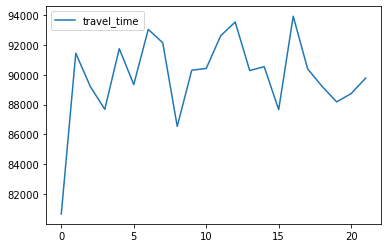

In [13]:
df_out.groupby(['date', 'origin', 'destination']).mean().reset_index().groupby(
    ['date']).sum()[['travel_time']].reset_index().sort_values(by = 'date').plot(y = 'travel_time')